## The Goal: Now that I've looked (at least briefly) at biases in latent heat flux, how about comparing with winds from CLUBB?

<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 28 Aug 2020<br>


In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle



## Read in data

In [3]:
# Read in bias 
fileDir  = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
fileName = 'LH_bias_annAvg_Wm2.p' 

annBias_avg = pickle.load( open(fileDir+fileName, "rb") )


To get the LHFLX files that are stored on /glade: <br>
sshfs -o allow_root mdfowler@casper.ucar.edu:/glade/work/mdfowler/data/CLUBB_sim gp_fuse <br>

In [4]:
# Set up file stuff to read in all the data 
remoteDir    = '/Users/meganfowler/gp_fuse/'
dataDir      = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'

nameStart    = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd      = '_CLUBBwinds.nc'
nameEnd_UV   = '_UV.nc'
nameEnd_flux = '_sfcFluxes.nc'

decadeList   = ['1980-89','1990-99','2000-14']


In [5]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [6]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
    flxFile = remoteDir+nameStart+decadeList[iDec]+nameEnd_flux
    flxDF   = xr.open_dataset(flxFile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
        fullFlx = flxDF 
    else:
        fullDF = xr.concat([fullDF, dataDF],  dim="time")
        fullUV = xr.concat([fullUV, windDF],  dim="time")
        fullFlx = xr.concat([fullFlx, flxDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullFlx['time']))
    

<ipython-input-6-29dd2da6f36f>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-6-29dd2da6f36f>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-6-29dd2da6f36f>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors i

Done with decade  1980-89  ... 
    Number of times saved:  120
Done with decade  1990-99  ... 
    Number of times saved:  240
Done with decade  2000-14  ... 
    Number of times saved:  420


## Some data processing 

In [7]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullFlx['time'].values) 

# Let's use the same period used to get LHFLX biases (1982-2008)
midTime = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 
iKeep   = np.where((midTime.year>=1982) & (midTime.year<=2008))[0]


In [10]:
# Now isolate variables, data selections, and flip levels 
LH  = fullFlx.LHFLX.values[iKeep,:,:]          # Latent heat flux (W/m2) 
UP2 = fullDF.UP2_CLUBB.values[iKeep,:,:,:]     # Zonal velocity variance (m2/s2)
U   = fullUV.U.values[iKeep,:,:,:]             # Zonal wind (m/s)

# Limit range of dates here too 
midTime = midTime[iKeep]

# Flip along vertical (level) axis, so that index 0 is surface 
UP2 = np.flip(UP2, axis=1)
U   = np.flip(U, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


Now let's compute seasonal averages 

In [12]:
# Now get averages of U and UP2
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]

U_DJF = np.nanmean(U[iDJF,0,:,:], axis=0)
U_MAM = np.nanmean(U[iMAM,0,:,:], axis=0)
U_JJA = np.nanmean(U[iJJA,0,:,:], axis=0)
U_SON = np.nanmean(U[iSON,0,:,:], axis=0)

UP2_DJF = np.nanmean(UP2[iDJF,1,:,:], axis=0)
UP2_MAM = np.nanmean(UP2[iMAM,1,:,:], axis=0)
UP2_JJA = np.nanmean(UP2[iJJA,1,:,:], axis=0)
UP2_SON = np.nanmean(UP2[iSON,1,:,:], axis=0)

LH_DJF = np.nanmean(LH[iDJF,:,:], axis=0)
LH_MAM = np.nanmean(LH[iMAM,:,:], axis=0)
LH_JJA = np.nanmean(LH[iJJA,:,:], axis=0)
LH_SON = np.nanmean(LH[iSON,:,:], axis=0)


## Start looking into regions

Take the approach of a 2D histogram, and represent density as a percentage of all gridcells in a given region. <br>
<br>A few things to look at: 
* What's the connection between U and LHFLX? 
* What's the connection between UP2 and LHFLX? 
* Ideally, what's the bias of LHFLX like in each region, and season, but <b>problem with that</b> - I only have annual average LHFLX it seems like, at least as downloaded from ILAMB. So I need to find a source of flux observations that I can get some kind of seasonal resolution from. Reanalysis? That's of course got it's own issues, but maybe... <br>


In [51]:
# Define regions next...
# Create 3D mask of the regions mapped out above 
#   (better for actually getting averages and masking out other regions)
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)


In [102]:
# Loop over regions... 
nRegions = len(RegMask.region.values)

# Set up bin edges for both vars
U_edges   = np.linspace(-10,10,31)
UP2_edges = np.linspace(0,0.5,31)
LH_edges  = np.linspace(-20, 80, 101)



In [108]:
# Save output 
H_UvUP2_DJF = np.full([nRegions,len(U_edges)-1,len(UP2_edges)-1], np.nan)
H_UvUP2_MAM = np.full([nRegions,len(U_edges)-1,len(UP2_edges)-1], np.nan)
H_UvUP2_JJA = np.full([nRegions,len(U_edges)-1,len(UP2_edges)-1], np.nan)
H_UvUP2_SON = np.full([nRegions,len(U_edges)-1,len(UP2_edges)-1], np.nan)

H_UvLH_DJF = np.full([nRegions,len(U_edges)-1,len(LH_edges)-1], np.nan)
H_UvLH_MAM = np.full([nRegions,len(U_edges)-1,len(LH_edges)-1], np.nan)
H_UvLH_JJA = np.full([nRegions,len(U_edges)-1,len(LH_edges)-1], np.nan)
H_UvLH_SON = np.full([nRegions,len(U_edges)-1,len(LH_edges)-1], np.nan)

H_UP2vLH_DJF = np.full([nRegions,len(UP2_edges)-1,len(LH_edges)-1], np.nan)
H_UP2vLH_MAM = np.full([nRegions,len(UP2_edges)-1,len(LH_edges)-1], np.nan)
H_UP2vLH_JJA = np.full([nRegions,len(UP2_edges)-1,len(LH_edges)-1], np.nan)
H_UP2vLH_SON = np.full([nRegions,len(UP2_edges)-1,len(LH_edges)-1], np.nan)


# ----- Loop over regions to get 2D histogram data ---- # 
for iReg in range(nRegions): 
    # Get indices of selected region 
    rSel = RegMask.sel(region=iReg+1)
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 
    
    # ---- Isolate regions of variables, flatten arrays ----- 
    U_regSel_DJF   = (U_DJF*rMask).reshape([len(lon)*len(lat)])
    U_regSel_MAM   = (U_MAM*rMask).reshape([len(lon)*len(lat)])
    U_regSel_JJA   = (U_JJA*rMask).reshape([len(lon)*len(lat)])
    U_regSel_SON   = (U_SON*rMask).reshape([len(lon)*len(lat)])
    
    UP2_regSel_DJF = (UP2_DJF*rMask).reshape([len(lon)*len(lat)])
    UP2_regSel_MAM = (UP2_MAM*rMask).reshape([len(lon)*len(lat)])
    UP2_regSel_JJA = (UP2_JJA*rMask).reshape([len(lon)*len(lat)])
    UP2_regSel_SON = (UP2_SON*rMask).reshape([len(lon)*len(lat)])
    
    LH_regSel_DJF  = (LH_DJF*rMask).reshape([len(lon)*len(lat)])
    LH_regSel_MAM  = (LH_MAM*rMask).reshape([len(lon)*len(lat)])
    LH_regSel_JJA  = (LH_JJA*rMask).reshape([len(lon)*len(lat)])
    LH_regSel_SON  = (LH_SON*rMask).reshape([len(lon)*len(lat)])
    
    # ----- Get 2D histogram info -----
    H_UvUP2_DJFtemp, U_edges, UP2_edges = np.histogram2d(U_regSel_DJF, UP2_regSel_DJF, bins=(U_edges, UP2_edges))
    H_UvUP2_MAMtemp, U_edges, UP2_edges = np.histogram2d(U_regSel_MAM, UP2_regSel_MAM, bins=(U_edges, UP2_edges))
    H_UvUP2_JJAtemp, U_edges, UP2_edges = np.histogram2d(U_regSel_JJA, UP2_regSel_JJA, bins=(U_edges, UP2_edges))
    H_UvUP2_SONtemp, U_edges, UP2_edges = np.histogram2d(U_regSel_SON, UP2_regSel_SON, bins=(U_edges, UP2_edges))
    
    H_UvLH_DJFtemp, U_edges, LH_edges = np.histogram2d(U_regSel_DJF, LH_regSel_DJF, bins=(U_edges, LH_edges))
    H_UvLH_MAMtemp, U_edges, LH_edges = np.histogram2d(U_regSel_MAM, LH_regSel_MAM, bins=(U_edges, LH_edges))
    H_UvLH_JJAtemp, U_edges, LH_edges = np.histogram2d(U_regSel_JJA, LH_regSel_JJA, bins=(U_edges, LH_edges))
    H_UvLH_SONtemp, U_edges, LH_edges = np.histogram2d(U_regSel_SON, LH_regSel_SON, bins=(U_edges, LH_edges))
    
    H_UP2vLH_DJFtemp, U_edges, LH_edges = np.histogram2d(UP2_regSel_DJF, LH_regSel_DJF, bins=(U_edges, LH_edges))
    H_UP2vLH_MAMtemp, U_edges, LH_edges = np.histogram2d(UP2_regSel_MAM, LH_regSel_MAM, bins=(U_edges, LH_edges))
    H_UP2vLH_JJAtemp, U_edges, LH_edges = np.histogram2d(UP2_regSel_JJA, LH_regSel_JJA, bins=(U_edges, LH_edges))
    H_UP2vLH_SONtemp, U_edges, LH_edges = np.histogram2d(UP2_regSel_SON, LH_regSel_SON, bins=(U_edges, LH_edges))
    
    # ----- Save all regions to large array -----
    #    Units are as fraction of gridcells in region; x100 to get pct 
    H_UvUP2_DJF[iReg,:,:] = (H_UvUP2_DJFtemp.T)/np.nansum(rTest) # Let each row list bins with common y range (part of how this function works)
    H_UvUP2_MAM[iReg,:,:] = (H_UvUP2_MAMtemp.T)/np.nansum(rTest)
    H_UvUP2_JJA[iReg,:,:] = (H_UvUP2_JJAtemp.T)/np.nansum(rTest)
    H_UvUP2_SON[iReg,:,:] = (H_UvUP2_SONtemp.T)/np.nansum(rTest)
    
    H_UvLH_DJF[iReg,:,:] = (H_UvLH_DJFtemp.T)/np.nansum(rTest) # Let each row list bins with common y range (part of how this function works)
    H_UvLH_MAM[iReg,:,:] = (H_UvLH_MAMtemp.T)/np.nansum(rTest)
    H_UvLH_JJA[iReg,:,:] = (H_UvLH_JJAtemp.T)/np.nansum(rTest)
    H_UvLH_SON[iReg,:,:] = (H_UvLH_SONtemp.T)/np.nansum(rTest)
    
    H_UP2vLH_DJF[iReg,:,:] = (H_UP2vLH_DJFtemp.T)/np.nansum(rTest) # Let each row list bins with common y range (part of how this function works)
    H_UP2vLH_MAM[iReg,:,:] = (H_UP2vLH_MAMtemp.T)/np.nansum(rTest)
    H_UP2vLH_JJA[iReg,:,:] = (H_UP2vLH_JJAtemp.T)/np.nansum(rTest)
    H_UP2vLH_SON[iReg,:,:] = (H_UP2vLH_SONtemp.T)/np.nansum(rTest)
    
    

ValueError: could not broadcast input array from shape (100,30) into shape (30,100)

In [109]:
np.shape(H_UvLH_DJFtemp)

(30, 100)

In [104]:
# --- Testing section to pick out region 

iReg = 0
rSel = RegMask.sel(region=iReg+1)

rTest = np.full([len(lat),len(lon)],np.nan)
rTest[rSel==True] = 1 

U_regSel_DJF   = (U_DJF*rTest).reshape([len(lon)*len(lat)])
UP2_regSel_DJF = (UP2_DJF*rTest).reshape([len(lon)*len(lat)])
LH_regSel_DJF  = (LH_DJF*rTest).reshape([len(lon)*len(lat)])

# plt.contourf(U_regSel_DJF)
# plt.colorbar() 



In [105]:
H_reg_DJF, U_edges, LH_edges = np.histogram2d(U_regSel_DJF, LH_regSel_DJF, bins=(U_edges, LH_edges))


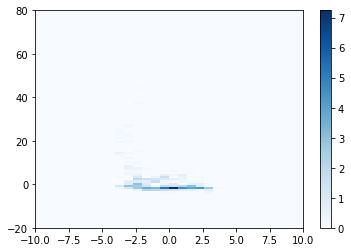

In [106]:
X,Y = np.meshgrid(U_edges, LH_edges)

plt.pcolormesh(X,Y, 100*((H_reg_DJF.T)/np.nansum(rTest)),cmap='Blues')
plt.colorbar()

In [94]:
np.nansum(~np.isnan(rTest))

663

In [95]:
(H_reg_DJF.T)/np.nansum(rTest)

(30, 30)